In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from torch.optim import AdamW
import os
import wandb
import numpy as np
import random
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from collections import defaultdict

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


#### Downloading model

In [4]:
model_path = "gpt2"
tokenizer_path = "gpt2"

In [5]:
tokenizer = GPT2Tokenizer.from_pretrained(tokenizer_path)
model = GPT2LMHeadModel.from_pretrained(model_path, output_hidden_states=True).to(device)
tokenizer.pad_token = tokenizer.eos_token

The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


#### Exploration of model and tokenizer

In [6]:
def prompt_model(input_text):
    input_ids = tokenizer.encode(input_text, return_tensors="pt").to(device)
    attention_mask = torch.ones(input_ids.shape, device=input_ids.device)
    pad_token_id = tokenizer.eos_token_id
    output = model.generate(input_ids, max_new_tokens=10, attention_mask=attention_mask, pad_token_id=pad_token_id)
    return tokenizer.decode(output[0])

In [7]:
print(prompt_model("11 + 3 ="))
print(prompt_model("What is 1 + 1?"))

The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


11 + 3 = 1.5

The first two points are
What is 1 + 1?

1 + 1 = 1 + 1



In [8]:
input_text = "15 + 6 = 15"
input_ids = tokenizer.encode(input_text, return_tensors="pt").to(device)
attention_mask = torch.ones(input_ids.shape, device=input_ids.device)
pad_token_id = tokenizer.eos_token_id
output = model(input_ids, max_new_tokens=1, attention_mask=attention_mask, pad_token_id=pad_token_id)
output.logits.shape


torch.Size([1, 5, 50257])

In [14]:
for i in range(-1, 530):
    input_text = str(i)
    input_ids = tokenizer.encode(input_text, return_tensors="pt").to(device)
    if (len(input_ids[0]) != 1):
        print(f'{i} is encoded with more than 1 token')

-1 is encoded with more than 1 token
521 is encoded with more than 1 token
527 is encoded with more than 1 token


In [17]:
tok_example = tokenizer("1 + 4 = 12", return_tensors="pt", max_length=6,
                               padding='max_length',
                               truncation=True).to(device)

In [18]:
print(tok_example["input_ids"])
print(tok_example["attention_mask"])

tensor([[   16,  1343,   604,   796,  1105, 50256]], device='cuda:0')
tensor([[1, 1, 1, 1, 1, 0]], device='cuda:0')


#### Creation of dataset

In [17]:
def generate_dataset():
    data = []
    for a in range(0, 250):
        for b in range(0, 250):
            c = a + b
            equation = f"{a} + {b} = {c}"
            data.append(equation)
    return data

def get_samples_from_segment(left, right, number):
    data = []
    for a in range(left, right + 1):
        for b in range(left, right + 1):
            c = a + b
            equation = f"{a} + {b} = {c}"
            data.append(equation)
    return random.sample(data, number)

def generate_train_dataset():
    data = []
    data += get_samples_from_segment(0, 10, 100)
    data += get_samples_from_segment(11, 100, 4000)
    data += get_samples_from_segment(0, 249, 10000)
    return list(set(data))


class AdditionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = 6  # We want model to predict end after number c
        # should use exactly 6 here

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        equation = self.data[idx]
        inputs = self.tokenizer(equation, return_tensors='pt',
                               max_length=self.max_length,
                               padding='max_length',
                               truncation=True)
        input_ids = inputs['input_ids'].squeeze(0)  # inputs['input_ids'].shape = (1, 5)
        attention_mask = inputs['attention_mask'].squeeze(0)
        return input_ids, attention_mask


all_data = generate_dataset()
dataset = AdditionDataset(all_data, tokenizer)

train_data = generate_train_dataset()
test_data = [elem for elem in get_samples_from_segment(0, 249, 2000) if elem not in train_data]


train_dataset = AdditionDataset(train_data, tokenizer)
test_dataset = AdditionDataset(test_data, tokenizer)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
eval_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


In [18]:
print(dataset.__len__(), train_dataset.__len__(), test_dataset.__len__())

62500 13459 1566


#### Fitting a Helix

In [19]:
def get_activation(prompt, layer_idx):
    inputs = tokenizer(prompt, return_tensors='pt').to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    hidden_states = outputs.hidden_states
    return hidden_states[layer_idx][0, 0].cpu().numpy()

In [20]:
layer_idx = 5

H_all = []
prompts_all = get_samples_from_segment(0, 249, 2000)
for prompt in tqdm(prompts_all):
    activation = get_activation(prompt, layer_idx)
    H_all.append(activation)
H_all = np.array(H_all)

100%|██████████| 2000/2000 [00:12<00:00, 161.62it/s]


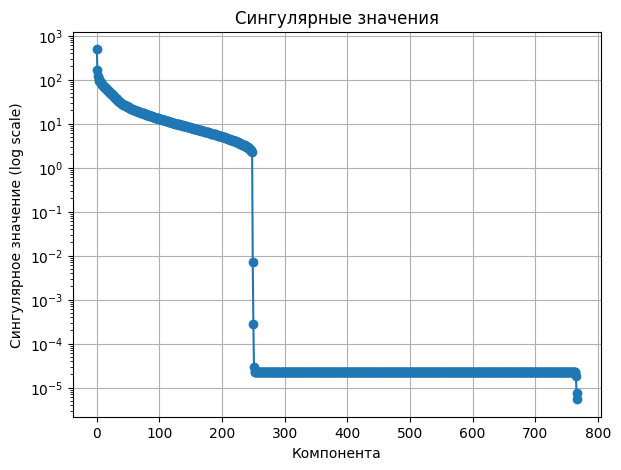

In [21]:
pca = PCA(n_components=None)
pca.fit(H_all)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(pca.singular_values_, 'o-')
plt.yscale('log')
plt.title('Сингулярные значения')
plt.xlabel('Компонента')
plt.ylabel('Сингулярное значение (log scale)')
plt.grid(True)

In [22]:
def find_coef_of_determination(layer_idx=5, target_variance=0.95):
    model.eval()
    H_all = []
    prompts_all = get_samples_from_segment(0, 249, 2000)
    a_states = defaultdict(list)
    a_vals = []

    for prompt in prompts_all:
        a_val = int(prompt.split()[0])
        activation = get_activation(prompt, layer_idx)
        a_states[a_val].append(activation)

    H_all = []
    for key, states in a_states.items():
        if len(states) == 0:
            continue
        a_vals.append(key)
        H_all.append(np.mean(states, axis=0))


    H_all = np.array(H_all)

    pca = PCA(n_components=None)
    H_pca = pca.fit_transform(H_all)
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    great_pca = np.argmax(cumulative_variance >= target_variance) + 1
    pca_dim = max(great_pca, 10)
    H_pca = H_pca[:, :pca_dim]

    periods = [2, 5, 10, 100]
    def build_fourier_features(a):
        features = []
        for period in periods:
            features.append(np.cos(2 * np.pi * a / period))
            features.append(np.sin(2 * np.pi * a / period))
        return np.array(features)

    B = np.array([build_fourier_features(a) for a in a_vals])

    reg = LinearRegression(fit_intercept=False)
    reg.fit(B, H_pca)
    r2 = reg.score(B, H_pca)
    return r2, pca_dim

In [24]:
print(find_coef_of_determination())

(0.11531165831977153, 56)


#### Fine-tuning

In [ ]:
no_decay = ["bias", "LayerNorm.weight"]
optimizer_grouped_parameters = [
    {
        "params": [
            p for n, p in model.named_parameters()
            if not any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.75,  # Веса матриц
    },
    {
        "params": [
            p for n, p in model.named_parameters()
            if any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.0,  # Bias и LayerNorm
    },
]

optimizer = AdamW(optimizer_grouped_parameters, lr=5e-5)

In [ ]:
# @torch.no_grad()
def compute_accuracy(model, data_loader):
    model.eval()
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for input_ids, attention_mask in data_loader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            for i in range(input_ids.shape[0]):
                seq = input_ids[i]
                mask = attention_mask[i]
                last_token_pos = torch.sum(mask).item() - 1  # don't include eos tokens

                pred_token = logits[i, last_token_pos - 1].argmax().item()
                true_token = seq[last_token_pos].item()

                if pred_token == true_token:
                    total_correct += 1
                total_samples += 1

    return total_correct / total_samples

In [ ]:
def compute_elem_loss(outputs, input_ids):
    logits = outputs.logits
    loss_function = torch.nn.CrossEntropyLoss()

    total_loss = 0

    for batch_id in range(logits.shape[0]):
        for i in range(2):
            pred = logits[batch_id, -3 + i]
            target = input_ids[batch_id, -2 + i]

            total_loss += loss_function(pred.unsqueeze(0), target.unsqueeze(0)) / 2

    return total_loss / logits.shape[0]


In [ ]:
wandb.login()

wandb: Currently logged in as: jegvide (jegvide-hse) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
best_eval_acc = 0
wandb.init(project="fine_tuning_gpt2_math")

In [ ]:
model.generation_config.return_dict_in_generate = True

In [ ]:
train_acc = compute_accuracy(model, train_loader)
eval_acc = compute_accuracy(model, eval_loader)
w_norm = torch.norm(torch.cat([p.view(-1) for n,p in model.named_parameters()
                                if "weight" in n and "LayerNorm" not in n])).item()
metrics = {
    "epoch": 0,
    "train_accuracy": train_acc,
    "eval_accuracy": eval_acc,
    "weight": w_norm
}

determination_1 = find_coef_of_determination(layer_idx=1)
metrics.update({"Coefficient of determination in layer 1": determination_1[0]})
metrics.update({"PCA dim in layer 1": determination_1[1]})

determination_6 = find_coef_of_determination(layer_idx=6)
metrics.update({"Coefficient of determination in layer 6": determination_6[0]})
metrics.update({"PCA dim in layer 6": determination_6[1]})

wandb.log(metrics)

In [ ]:
num_epochs = 200
for epoch in range(1, num_epochs):
    model.train()
    total_loss = 0
    for batch_idx, (input_ids, attention_mask) in enumerate(train_loader):
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)
        loss = compute_elem_loss(outputs, input_ids)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        wandb.log({"batch_loss": loss.item()})

    avg_train_loss = total_loss / len(train_loader)
    train_acc = compute_accuracy(model, train_loader)
    eval_acc = compute_accuracy(model, eval_loader)
    w_norm = torch.norm(torch.cat([p.view(-1) for n,p in model.named_parameters()
                                  if "weight" in n and "LayerNorm" not in n])).item()

    if best_eval_acc < eval_acc:
        best_eval_acc = eval_acc
        epoch_dir = f"data/saved_models/epoch_{epoch}"
        os.makedirs(epoch_dir, exist_ok=True)
        model.save_pretrained(epoch_dir)

    metrics = {
        "epoch": epoch,
        "train_loss": avg_train_loss,
        "train_accuracy": train_acc,
        "eval_accuracy": eval_acc,
        "weight": w_norm
    }

    if (epoch % 7 == 0):
        determination_1 = find_coef_of_determination(layer_idx=1)
        metrics.update({"Coefficient of determination in layer 1": determination_1[0]})
        metrics.update({"PCA dim in layer 1": determination_1[1]})

        determination_6 = find_coef_of_determination(layer_idx=6)
        metrics.update({"Coefficient of determination in layer 6": determination_6[0]})
        metrics.update({"PCA dim in layer 6": determination_6[1]})

    wandb.log(metrics)

    print(f"Epoch {epoch}: Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, Eval Acc: {eval_acc:.4f}, Weight: {w_norm:.4f}")


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Epoch 1: Train Loss: 2.1941, Train Acc: 0.0723, Eval Acc: 0.0459, Weight: 1458.3666
Epoch 2: Train Loss: 1.8161, Train Acc: 0.0984, Eval Acc: 0.0567, Weight: 1413.3647
Epoch 3: Train Loss: 1.6617, Train Acc: 0.1433, Eval Acc: 0.0739, Weight: 1369.7924
Epoch 4: Train Loss: 1.5265, Train Acc: 0.2344, Eval Acc: 0.1428, Weight: 1327.6339
Epoch 5: Train Loss: 1.3781, Train Acc: 0.3366, Eval Acc: 0.1823, Weight: 1286.8477
Epoch 6: Train Loss: 1.0803, Train Acc: 0.7188, Eval Acc: 0.4920, Weight: 1247.4399
Epoch 7: Train Loss: 0.5298, Train Acc: 0.9064, Eval Acc: 0.7451, Weight: 1209.1431
Epoch 8: Train Loss: 0.3352, Train Acc: 0.9549, Eval Acc: 0.8368, Weight: 1172.0499
Epoch 9: Train Loss: 0.2555, Train Acc: 0.9604, Eval Acc: 0.8859, Weight: 1136.0742
Epoch 10: Train Loss: 0.2225, Train Acc: 0.9748, Eval Acc: 0.9203, Weight: 1101.2855
Epoch 11: Train Loss: 0.1813, Train Acc: 0.9822, Eval Acc: 0.9496, Weight: 1067.8309
Epoch 12: Train Loss: 0.1672, Train Acc: 0.9715, Eval Acc: 0.9375, Weight:

KeyboardInterrupt: 

In [ ]:
wandb.finish()

#### Model saving

In [7]:
model.save_pretrained("data/saved_models/last_model")
# tokenizer.save_pretrained("data/saved_models/last_model")

#### New model exploration

In [ ]:
model.generation_config.return_dict_in_generate = False

In [ ]:
input_text = "120 + 162 ="
input_ids = tokenizer.encode(input_text, return_tensors="pt").to(device)
print(input_ids)

output = model.generate(input_ids, max_new_tokens=1)

print(tokenizer.decode(output[0], skip_special_tokens=True))


The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[10232,  1343, 25090,   796]], device='cuda:0')
120 + 162 = 282


In [ ]:
def find_coef_of_determination_with_a(layer_idx=5, target_variance=0.95):
    model.eval()
    H_all = []
    prompts_all = get_samples_from_segment(0, 249, 2000)
    a_states = defaultdict(list)
    a_vals = []

    for prompt in prompts_all:
        a_val = int(prompt.split()[0])
        activation = get_activation(prompt, layer_idx)
        a_states[a_val].append(activation)

    H_all = []
    for key, states in a_states.items():
        if len(states) == 0:
            continue
        a_vals.append(key)
        H_all.append(np.mean(states, axis=0))


    H_all = np.array(H_all)

    pca = PCA(n_components=None)
    H_pca = pca.fit_transform(H_all)
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    great_pca = np.argmax(cumulative_variance >= target_variance) + 1
    pca_dim = great_pca
    H_pca = H_pca[:, :pca_dim]

    periods = [2, 5, 10, 100]
    def build_fourier_features(a):
        features = [a]
        for period in periods:
            features.append(np.cos(2 * np.pi * a / period))
            features.append(np.sin(2 * np.pi * a / period))
        return np.array(features)

    B = np.array([build_fourier_features(a) for a in a_vals])

    reg = LinearRegression(fit_intercept=False)
    reg.fit(B, H_pca)
    r2 = reg.score(B, H_pca)
    return r2, pca_dim

In [ ]:
print(find_coef_of_determination_with_a(layer_idx=5, target_variance=0.5))

(0.9481515495217496, np.int64(4))


In [ ]:
print(find_coef_of_determination(layer_idx=5))

(0.4894626102784992, np.int64(10))


In [ ]:
print(find_coef_of_determination_with_a(layer_idx=10))
print(find_coef_of_determination(layer_idx=10))

(0.5151757132953777, np.int64(10))
(0.4893914642598351, np.int64(10))
